### Classifying newswires 🗞

In [1]:
data_length=10000

#### Loading the Reuters dataset

The argument *num_words* means we’ll only keep the top *num_words* most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=data_length)

#### Preparing the data

We will turn the lists into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then we will use as the first layer in our network a Dense layer, capable of handling floating-point vector data.

In [3]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels we'll use one-hot encoding which is a widely used format for categorical data, also called categorical encoding. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. There is a built-in way to do this in Keras.

In [4]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

#### Building the network

In a stack of Dense layers each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck.

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(data_length,)))
model.add(layers.Dense(64, activation='relu'))

We end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

In [6]:
model.add(layers.Dense(46, activation='softmax'))

The last layer uses a softmax activation. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

#### Compiling the model

The best loss function to use in this case is *categorical_crossentropy*. It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels. By minimizing the distance between these two distributions, we train the network to output something as close as possible to the true labels.

In [7]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Setting aside a validation set

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [8]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

#### Training the model

In [9]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 188us/step - loss: 2.5032 - acc: 0.5357 - val_loss: 1.7086 - val_acc: 0.6490
Epoch 2/20
7982/7982 [==============================] - 1s 139us/step - loss: 1.4024 - acc: 0.7012 - val_loss: 1.3307 - val_acc: 0.7020
Epoch 3/20
7982/7982 [==============================] - 1s 130us/step - loss: 1.0612 - acc: 0.7642 - val_loss: 1.1501 - val_acc: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.8369 - acc: 0.8216 - val_loss: 1.0303 - val_acc: 0.7870
Epoch 5/20
7982/7982 [==============================] - 1s 131us/step - loss: 0.6600 - acc: 0.8601 - val_loss: 0.9699 - val_acc: 0.8000
Epoch 6/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.5287 - acc: 0.8884 - val_loss: 0.9336 - val_acc: 0.8090
Epoch 7/20
7982/7982 [==============================] - 1s 135us/step - loss: 0.4233 - acc: 0.9117 - val_loss: 0.9108 - val_acc: 0.8190


#### Plotting the training and validation loss

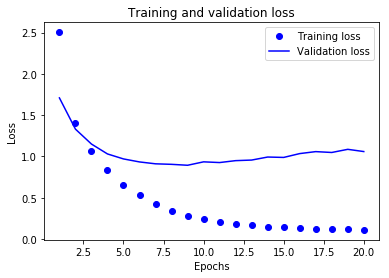

In [11]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Plotting the training and validation accuracy

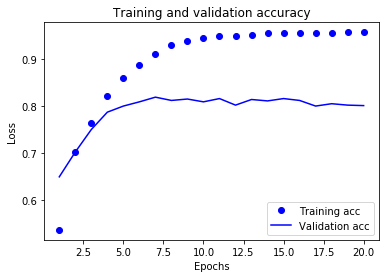

In [12]:
plt.clf()

acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The network begins to overfit after nine epochs. At this point we should train the network from scratch for nine epochs and then evaluate it on the test set.